# Geography based Sentiment Analysis using Twitter data

Jigar Mehta, Vishesh Dosaj

Team DataMiners

Data Programming, Fall 2015

Date : Dec 10th, 2015

Sentiment analysis (also known as opinion mining) refers to the use of natural language processing, text analysis and computational linguistics to identify and extract subjective information in source materials.

# Problem Statement and Project Summary:

In this project, we are analyzing the twitter data about two largest e-commerce giants - amazon and ebay - to calcuate sentiment - the public's opinion about the two, aggregated at US state level. This project will help to understand and compare the brand image of two companies across US with interesting KPIs and impressive visualizations. The ability to quickly understand consumer attitudes and experience prevents spread of negative sentiment on the social media website. It helps to win back the agitated customers and prevents to hold on to future potential customers.

# Implementation

In [39]:
# import packages and modules

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import operator 
from collections import Counter
import collections
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#define twitter API access connection parameters

a=0 # count stopper
#Variables that contains the user credentials to access Twitter API 
access_token = "4124694807-9UnjCCudHbNThtLlQjwNFRjBBTwdL5AvTroOcKi"
access_token_secret = "CYyJfefmmByIoSk7smJD0E7V2y0wjVrszWCA7Mdm46ZCQ"
consumer_key = "3Z8Tyk9X6PPwghK4qFEy9tVYH"
consumer_secret = "v8PdHTg3pxuj8RrWUXhUGib4RBvSrBebUE57dEvrPvpKfbk5km"

# Step 1: Web Scraping --> Download the Twitter data and upload to mongo db

In [ ]:
#Twitter data streaming class
class StdOutListener(StreamListener):
    
    def on_data(self, data):
        try:
            global a
            while a<100:
                with open('p_amaz.json', 'a') as f:
                    f.write(data)
                    a=a+1
                    print a
                    return True
            else:
                return False
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

    def on_error(self, status):
        print status
        return True

#download the twitter data
    # main class
if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords - Amazon and Ebay:
    stream.filter(track=['Amazon'])
    # stream.filter(track=['ebay'])

# Connect Mongo Db from Python

In [49]:
# connect to mongo db from python
import pandas as pd
from pandas.io.json import json_normalize
from bson import json_util, ObjectId
import json
import glob
from pymongo import MongoClient

#convert mongo db documents to Pandas Dataframe
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        normalized = json_normalize(sanitized)
        df = pd.DataFrame(normalized)

        return df

cl = MongoClient()
db = cl.test

In [50]:
# ebay documents to dataframe
cursora = db.ebay.find()
eb1=mongo_to_dataframe(cursora)
eb1.shape
#filter tweets for language only in english
eb1=eb1[eb1['lang']=='en']
eb1.shape

(14113, 298)

In [51]:
# amazon documents to dataframe
cursorb = db.amaz.find()
db1=mongo_to_dataframe(cursorb)
db1.shape

#filter tweets for language only in english
db1=db1[db1['lang']=='en']
db1.shape

(13743, 311)

# Data Cleaning

In [52]:
# lowercase..tokenization...then removing english language stop words, customized stopwords and punctuations 
#import required packages and modules

import re
from nltk.corpus import stopwords
from nltk import bigrams 
import string
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

from nltk.corpus import stopwords
from nltk import bigrams 
import string

#stop words
punctuation = list(string.punctuation)
stop=stopwords.words('english') + punctuation
stop=stop+ ['Read','ebay','Ebay','eBay','10','Please','8','16','7','Now','Only', 'New', 'GB','4',\
            'NEW','5','6','\u2026','HOLY','25','Gift','pm','2','1','Entire','follows','d83d','6.00','A',\
            'give','dogs','dog','amp','The','I','away','person','giving','one','random','tweet','rt','50',\
            'EST','3','RTs','RT','\u2026','Amazon','Clinton', 'via']

In [40]:
# Import positive and negative words from General Inquirer dictionary
positive=[]
negative=[]
keys_to_ignore = ['Entry','Source','Defined']
with open('general_inquirer_dict.txt') as fin:
    reader = csv.DictReader(fin,delimiter='\t')
    for i,line in enumerate(reader):
        if line['Negativ']=='Negativ':
            if line['Entry'].find('#')==-1:
                negative.append(line['Entry'].lower())
            if line['Entry'].find('#')!=-1: #In General Inquirer, some words have multiple senses. Combine all tags for all senses.
                negative.append(line['Entry'].lower()[:line['Entry'].index('#')]) 
        if line['Positiv']=='Positiv':
            if line['Entry'].find('#')==-1:
                positive.append(line['Entry'].lower())
            if line['Entry'].find('#')!=-1: #In General Inquirer, some words have multiple senses. Combine all tags for all senses.
                positive.append(line['Entry'].lower()[:line['Entry'].index('#')])

pvocabulary=sorted(list(set(positive))) #In General Inquirer, some words have multiple senses. Combine all tags for all senses.
nvocabulary=sorted(list(set(negative))) #In General Inquirer, some words have multiple senses. Combine all tags for all senses.

# Descriptive Analysis and major KPIs

In [8]:
# Calculate the major KPIs 
p=n=0
for text in db1['text']:
    for term in preprocess(text):
        if term not in stop and not term.startswith(('@','#','http')):
           
            if term in pvocabulary:
                p+=1
            elif term in nvocabulary:
                n+=1
e=f=0
for text in eb1['text']:
    for term in preprocess(text):
        if term not in stop and not term.startswith(('@','#','http')):
           
            if term in pvocabulary:
                e+=1
            elif term in nvocabulary:
                f+=1                
print "Positive to Negative words ratio for Amazon = "+str(format(round(1.0*p/n,1),"<0.1f")) 
print "Positive to Negative words ratio for ebay= "+str(format(round(1.0*e/f,1),"<0.1f")) 

Positive to Negative words ratio for Amazon = 2.6
Positive to Negative words ratio for ebay= 2.3


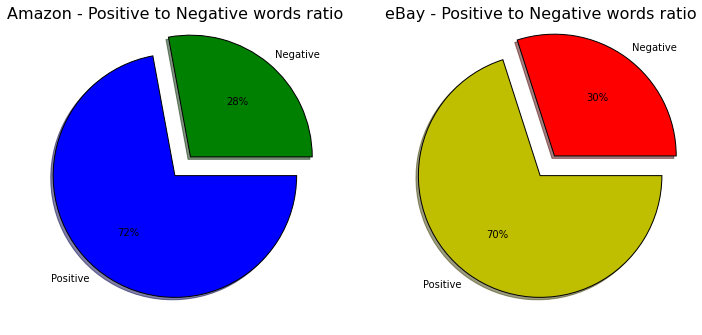

In [9]:
#Pie Charts
%matplotlib inline
import matplotlib.pyplot as plt

values = [5536, 2142]
colors = ['b', 'g']
labels = ['Positive', 'Negative']
explode = (0, 0.2)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1)
# autopct the %.1f is Python formating and %% used to show as percent
ax.pie(values, colors=colors, labels=labels,
        explode=explode, autopct='%.0f%%',
        counterclock=False, shadow=True)
ax.set_title('Amazon - Positive to Negative words ratio',fontsize=16)

values = [1125, 481]
colors = ['y', 'r']
labels = ['Positive', 'Negative']
explode = (0, 0.2)
ax1 = fig.add_subplot(2,2,2)
# autopct the %.1f is Python formating and %% used to show as percent
ax1.pie(values, colors=colors, labels=labels, 
        explode=explode, autopct='%.0f%%',
        counterclock=False, shadow=True)
ax1.set_title('eBay - Positive to Negative words ratio',fontsize=16)
plt.show()

In [53]:
# KPIs
spta=318.7 # calculated with time and lag
spte=185.8 

user = []
for text in db1['user.id']:
    user.append(text)
a=set(user)

usere=[]
for text in eb1['user.id']:
    usere.append(text)
b=set(usere)

reach=0.0
reach=float(len(a))/float(len(db1.index))

reache=0.0
reache=float(len(b))/float(len(eb1.index))

db2=pd.DataFrame(db1['user.screen_name'])
group=db2.groupby(['user.screen_name'])
size=group.size()

Passion_Score=float(len(size[size > 1]))/float(len(a))

eb2=pd.DataFrame(eb1['user.screen_name'])
groupe=eb2.groupby(['user.screen_name'])
sizee=groupe.size()
Passion_Score_e=float(len(sizee[sizee > 1]))/float(len(b))

# Word Clouds - amazon and eBay - Top keywords

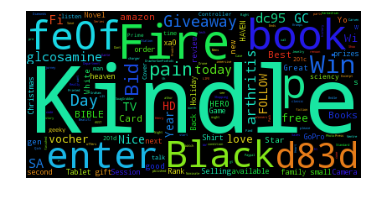

In [36]:
#Amazon word cloud
from os import path
from wordcloud import WordCloud
%matplotlib inline

# Read the whole text.
text = open('amaz.txt').read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)


plt.axis("off")
plt.show()
#plt.figure()
#plt.imshow(wordcloud)

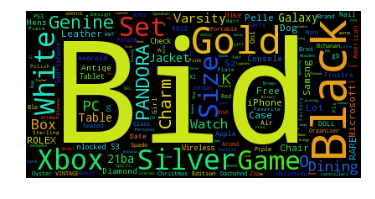

In [37]:
#eBay word cloud
%matplotlib inline
# Read the whole text.
text = open('ebay.txt').read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)


plt.axis("off")
plt.show()
#plt.figure()
#plt.imshow(wordcloud)

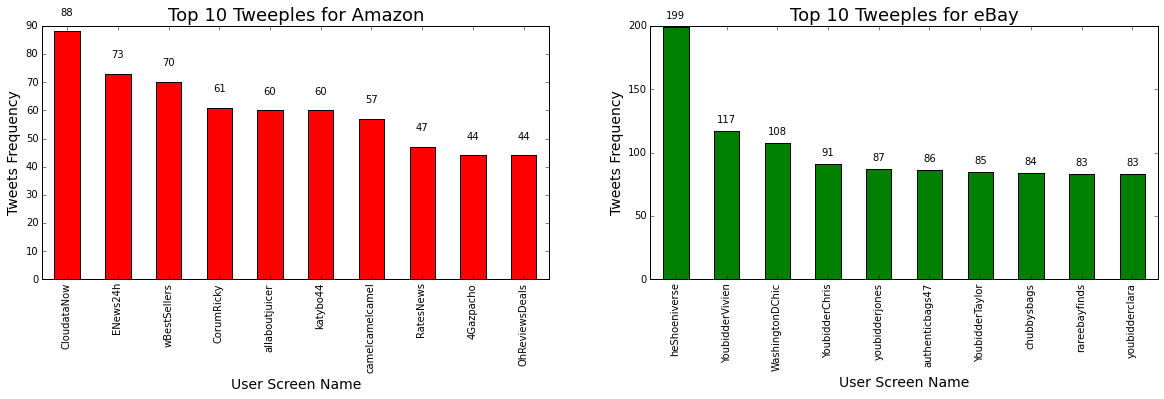

In [158]:
# Top 10 Tweeples --> Users who tweets the most
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

frequencies = [199,117,108,91,87,86,85,84,83,83]   # bring some raw data
fra=[88,73,70,61,60,60,57,47,44,44]

freq_series = pd.Series.from_array(frequencies)
freq_ = pd.Series.from_array(fra)
colors1 = ['g', 'g', 'g', 'g','g', 'g','g', 'g','g', 'g']
x_labels = ['heShoeniverse','YoubidderVivien' ,'WashingtonDChic','YoubidderChris','youbidderjones','authenticbags47','YoubidderTaylor','chubbysbags','rareebayfinds','youbidderclara']
x_la=['CloudataNow','ENews24h','wBestSellers','CorumRicky','allaboutjuicer','katybo44','camelcamelcamel','RatesNews','4Gazpacho','OhReviewsDeals']
# now to plot the figure...
fig = plt.figure(figsize=(20,10),dpi=150)
ax = fig.add_subplot(2,2,2)
ax.grid(True,which='both')
ax = freq_series.plot(kind='bar',colors=colors1)
ax.set_title("Top 10 Tweeples for eBay",fontsize=18)
ax.set_xlabel("User Screen Name",fontsize=14)
ax.set_ylabel("Tweets Frequency",fontsize=14)
ax.set_xticklabels(x_labels)

rects = ax.patches

# Now make some labels
labels = [199,117,108,91,87,86,85,84,83,83]
colors = ['r', 'r', 'r', 'r','r', 'r','r', 'r','r', 'r']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax1 = fig.add_subplot(2,2,1)
ax1.grid(True,which='both')
ax1 = freq_.plot(kind='bar',colors=colors)
ax1.set_title("Top 10 Tweeples for Amazon",fontsize=18)
ax1.set_xlabel("User Screen Name",fontsize=14)
ax1.set_ylabel("Tweets Frequency",fontsize=14)
ax1.set_xticklabels(x_la)
rects1 = ax1.patches
frequencies = [199,117,108,91,87,86,85,84,83,83]
for rect, label in zip(rects1, fra):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


# Comparison Dashboard using Tkinter 

Run the next section to see the dashboard open in a separate window..worth seeing it !

In [56]:
# Display KPIs using Tkinter
import Tkinter as t
%matplotlib inline
mas=t.Tk()
mas.title("Amazon vs eBay : Comparison of major KPIs")
canvas = t.Canvas(width=1100, height=510, bg='white') 

canvas.pack(expand=t.YES, fill=t.BOTH)                   
logo = t.PhotoImage(file="amaz.gif")
logo1 = t.PhotoImage(file="ebay.gif")
mycolor = '#%02x%02x%02x' % (255, 153, 0)
e = '#%02x%02x%02x' % (255, 0, 0)
b = '#%02x%02x%02x' % (0,0,153)
a = '#%02x%02x%02x' % (255,204, 0)
y = '#%02x%02x%02x' % (153,204, 0)

w = t.Label(canvas, compound = t.CENTER,image=logo)    
w1 = t.Label(canvas, text='Total Number of tweets = 13,743', bg=mycolor,fg='black',font="Helvetica 13  bold",height =2, width=48)
w2 = t.Label(canvas, text='Total Number of unique tweeples = 8,123', fg='black',bg='white',font="Helvetica 13  bold",height =2, width=48)
w3 = t.Label(canvas, text='Avg. tweets per tweeple = 1.7', fg='black',bg=mycolor,font="Helvetica 13  bold",height =2, width=48)
w4 = t.Label(canvas, text='Avg. Time per tweet = 318.7 ms', fg='black',bg='white',font="Helvetica 13  bold",height =2, width=48)
w5 = t.Label(canvas, text='Reach=59%', fg='black',font="Helvetica 13 bold",height =1, width=10,bg=mycolor)
w6 = t.Label(canvas, text='Passion=22%', fg='black',font="Helvetica 13 bold",height =1, width=11,bg=mycolor)
w7 = t.Label(canvas, text='Pos to Neg words ratio =  2.6', fg='black',font="Helvetica 12 bold",height =1, width=23,bg=mycolor)
canvas_id=canvas.create_text(50, 400,anchor='nw')
canvas.itemconfig(canvas_id,text="Reach is a measure of the range of influence. It is the total number of unique users referecing your brand divided by total number of tweets")
canvas_id=canvas.create_text(50, 430,anchor='nw')
canvas.itemconfig(canvas_id, text="Passion is a measure of the likelihood that individuals talking about brand will do so repeatedly.")
canvas_id=canvas.create_text(50, 445,anchor='nw')
canvas.itemconfig(canvas_id, text="It is calculated as total number of tweets by total number of unique users.")
canvas_id=canvas.create_text(50, 475,anchor='nw')
canvas.itemconfig(canvas_id, text="Sentiment : Pos to Neg words ratio")
canvas_id=canvas.create_text(50, 490,anchor='nw')
canvas.itemconfig(canvas_id, text="It is calculated as total number of tweets by total number of unique users.")
                  
w.pack()
w1.pack()
w2.pack()
w3.pack()
w4.pack()
w5.pack()
w6.pack()
w7.pack()

canvas.create_window(290, 90, window=w)
canvas.create_window(290, 200, window=w1)    
canvas.create_window(290, 240, window=w2)  
canvas.create_window(290, 280, window=w3)    
canvas.create_window(290, 320, window=w4)   
canvas.create_window(100, 360, window=w5)    
canvas.create_window(225, 360, window=w6)   
canvas.create_window(415, 360, window=w7)  

z = t.Label(canvas, compound = t.CENTER,image=logo1)    
z1 = t.Label(canvas, text='Total Number of tweets = 14,113', bg=a,fg='black',font="Helvetica 13  bold",height =2, width=48)
z2 = t.Label(canvas, text='Total Number of unique tweeples = 1,998', fg='black',bg='white',font="Helvetica 13  bold",height =2, width=48)
z3 = t.Label(canvas, text='Avg. tweets per tweeple = 7.1', fg='black',bg=a,font="Helvetica 13  bold",height =2, width=48)
z4 = t.Label(canvas, text='Avg. Time per tweet = 185.8 ms', fg='black',bg='white',font="Helvetica 13  bold",height =2, width=48)
z5 = t.Label(canvas, text='Reach=14%', fg='black',font="Helvetica 13 bold",height =1, width=10,bg=a)
z6 = t.Label(canvas, text='Passion=46%', fg='black',font="Helvetica 13 bold",height =1, width=11,bg=a)
z7 = t.Label(canvas, text='Pos to Neg words ratio =  2.3', fg='black',font="Helvetica 12 bold",height =1, width=22,bg=a)

z.pack()
z1.pack()
z2.pack()
z3.pack()
z4.pack()
z5.pack()
z6.pack()
z7.pack()

canvas.create_window(810, 90, window=z)
canvas.create_window(810, 200, window=z1 )   
canvas.create_window(810, 240, window=z2)  
canvas.create_window(810, 280, window=z3)    
canvas.create_window(810, 320, window=z4)   
canvas.create_window(620, 360, window=z5)    
canvas.create_window(750, 360, window=z6)   
canvas.create_window(940, 360, window=z7)    

t.mainloop()

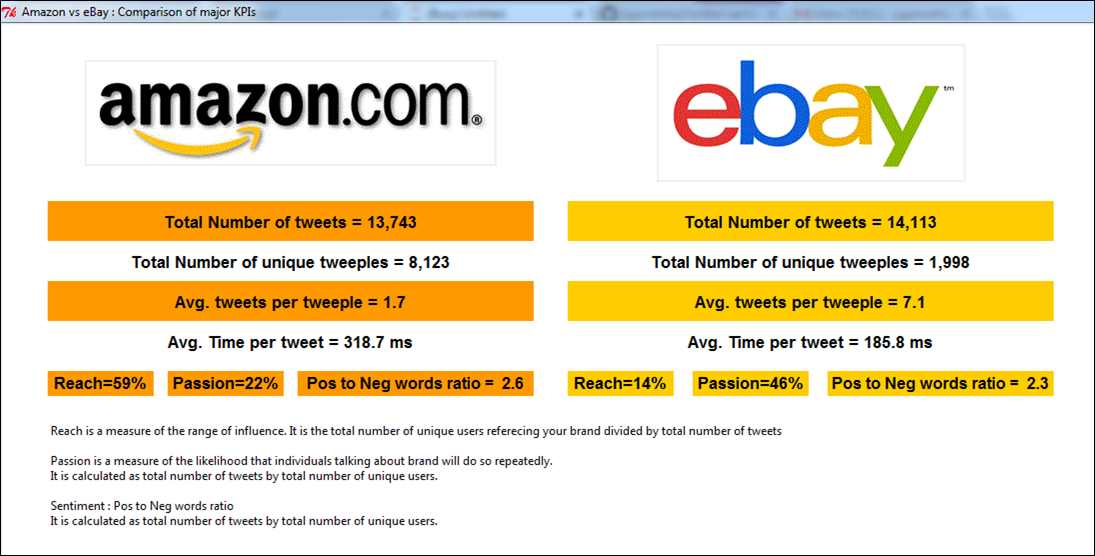

In [62]:
from IPython.display import Image
Image(filename='tk.png')

#  amazon vs eBay - Top Keywords, Hashtags and @-Mentions

In [54]:
# Amazon - Top parameters
from nltk import bigrams
from collections import Counter
#Top Keywords
count_bigram=Counter()
count_all = Counter()
for text in db1['text']:
    terms_all = [term for term in preprocess(text) if term not in stop and not term.startswith(('@','#','http'))]
    terms_bigram = bigrams(terms_all)
    count_all.update(terms_all)
    count_bigram.update(terms_bigram)
m1=(count_all.most_common(15))
bi=(count_bigram.most_common(15))

#Top Hashtags   
count_hash = Counter()
for text in db1['text']:
    terms_hash = [term for term in preprocess(text) if term.startswith('#')]
    terms_hash=[c.lower() for c in terms_hash]
    count_hash.update(terms_hash)
m2=(count_hash.most_common(15))

#Top @-Mentions  
count_at = Counter()
for text in db1['text']:
    terms_at = [term for term in preprocess(text) if term.startswith('@')]
    count_at.update(terms_at)
m3=(count_at.most_common(20))
    
# eBay - Top parameters
#Top Keywords
stop=stop+ ['Read','ebay','Ebay','eBay','10','Please','8','16','7','Now','Only', 'New', 'GB','4','NEW','5','6','\u2026','HOLY','25','Gift','pm','2','1','Entire','follows','d83d','6.00','A','give','dogs','dog','amp','The','I','away','person','giving','one','random','tweet','rt','50','EST','3','RTs','RT','\u2026','Amazon','Clinton', 'via']
count_all = Counter()
for text in eb1['text']:
    terms_all = [term for term in preprocess(text) if term not in stop and not term.startswith(('@','#','http'))]
    count_all.update(terms_all)
m4=(count_all.most_common(15))

#Top Hashtags   
count_hash = Counter()
for text in eb1['text']:
    terms_hash = [term for term in preprocess(text) if term.startswith('#')]
    terms_hash=[c.lower() for c in terms_hash]
    count_hash.update(terms_hash)
m5=(count_hash.most_common(15))

#Top @-Mentions  
count_at = Counter()
for text in eb1['text']:
    terms_at = [term for term in preprocess(text) if term.startswith('@')]
    count_at.update(terms_at)
m6=(count_at.most_common(20))

In [57]:
# clean the stuborn keywords
d1=pd.DataFrame(m1,columns=['key','val'])
d1=d1.drop(d1.index[[0,6,8,10,14]])
d1=d1.reset_index(drop=True)

d2=pd.DataFrame(m2,columns=['key','val'])
d2=d2.drop(d2.index[[0,2,3,5,10]])
d2= d2.reset_index(drop=True)

d3=pd.DataFrame(m3,columns=['key','val'])
d3=d3.drop(d3.index[[1,6,9]])
d3=d3[:10]
d3= d3.reset_index(drop=True)

d4=pd.DataFrame(m4,columns=['key','val'])
d4=d4.drop(d4.index[[0,3]])
d4=d4[:10]
d4= d4.reset_index(drop=True)

d5=pd.DataFrame(m5,columns=['key','val'])
d5=d5.drop(d5.index[[0,2,8]])
d5=d5[:10]
d5= d5.reset_index(drop=True)

d6=pd.DataFrame(m6,columns=['key','val'])
d6=d6.drop(d6.index[[0,3,10,11]])
d6=d6[:10]
d6= d6.reset_index(drop=True)

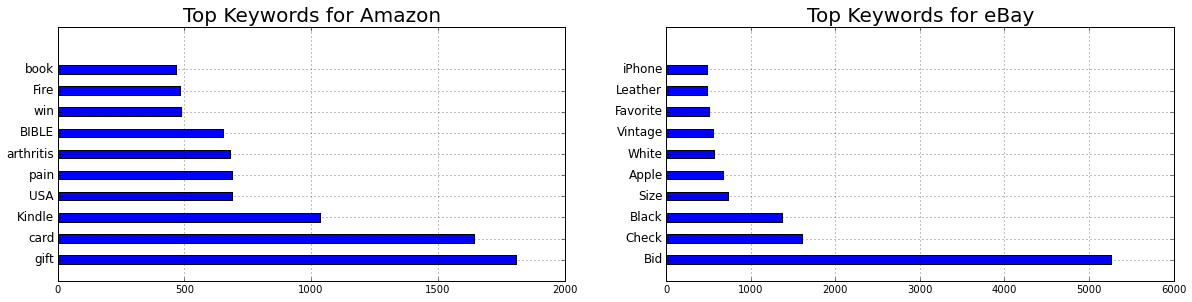

In [133]:
#Bar Charts for Top Keywords
import matplotlib as mpl
%matplotlib inline
mpl.use('Agg')
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10),dpi=150)

ax = fig.add_subplot(2,2,1)
ax.grid(True,which='both')
bar = ax.barh(range(1,len(d1)+1,1),d1['val'],0.4,align='center')
plt.yticks(range(1,len(d1)+1,1), d1['key'], size='large')
plt.title("Top Keywords for Amazon",fontsize=20)
ax1 = fig.add_subplot(2,2,2)
ax1.grid(True,which='both')
bar1 = ax1.barh(range(1,len(d4)+1,1),d4['val'],0.4,align='center')
plt.yticks(range(1,len(d4)+1,1), d4['key'], size='large')
plt.title("Top Keywords for eBay",fontsize=20)
plt.show()

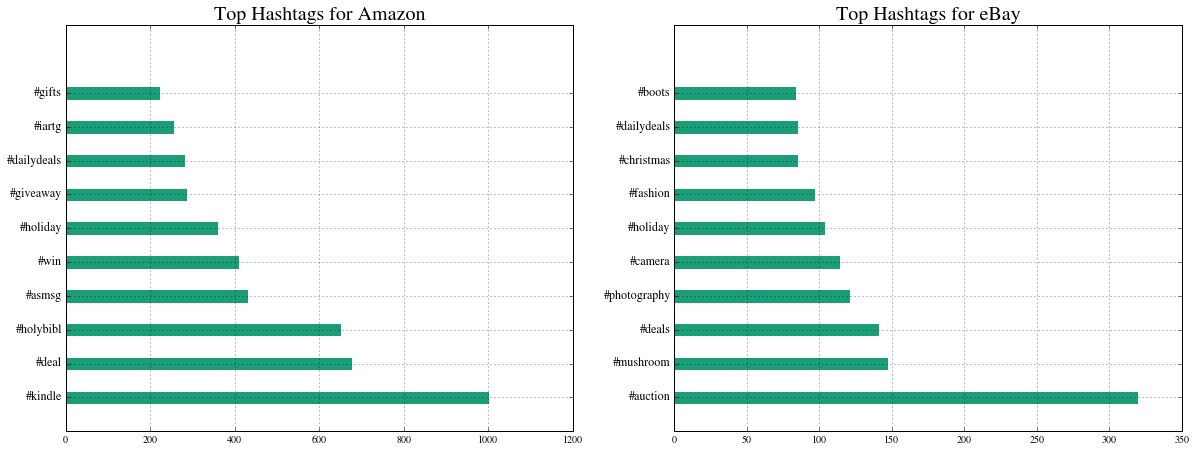

In [63]:
#Bar Charts for Top Hashtags

fig = plt.figure(figsize=(20,16),dpi=150)

ax = fig.add_subplot(2,2,1)
ax.grid(True,which='both')
bar = ax.barh(range(1,len(d2)+1,1),d2['val'],0.4,align='center')
plt.yticks(range(1,len(d2)+1,1), d2['key'], size='large')
plt.title("Top Hashtags for Amazon",fontsize=20)
ax1 = fig.add_subplot(2,2,2)
ax1.grid(True,which='both')
bar1 = ax1.barh(range(1,len(d5)+1,1),d5['val'],0.4,align='center')
plt.yticks(range(1,len(d5)+1,1), d5['key'], size='large')
plt.title("Top Hashtags for eBay",fontsize=20)
plt.show()

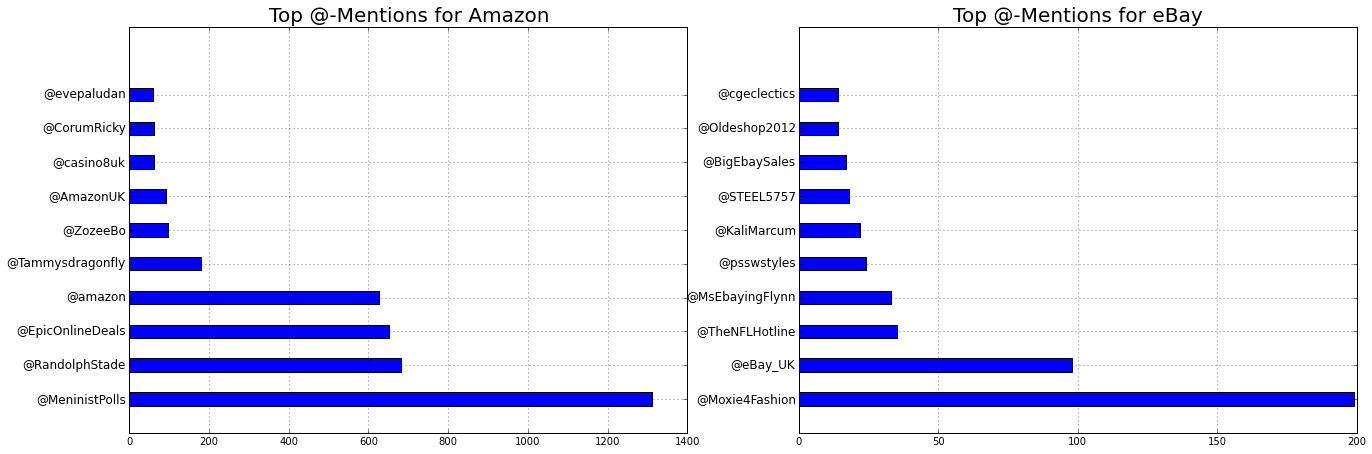

In [143]:
#Bar Charts for Top @-Mentions
import matplotlib as mpl
%matplotlib inline
mpl.use('Agg')
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(22,16),dpi=250)

ax = fig.add_subplot(2,2,1)
ax.grid(True,which='both')
bar = ax.barh(range(1,len(d3)+1,1),d3['val'],0.4,align='center')
plt.yticks(range(1,len(d3)+1,1), d3['key'], size='large')
plt.title("Top @-Mentions for Amazon",fontsize=20)
ax1 = fig.add_subplot(2,2,2)
ax1.grid(True,which='both')
bar1 = ax1.barh(range(1,len(d6)+1,1),d6['val'],0.4,align='center')
plt.yticks(range(1,len(d6)+1,1), d6['key'], size='large')
plt.title("Top @-Mentions for eBay",fontsize=20)
plt.show()

# Naive Bayes Classification Model

A Naive Bayes classifier is a simple probabilistic model based on the Bayes rule along with a strong independence assumption. That is given a class (positive or negative), the words are conditionally independent of each other. This assumption does not affect the accuracy in text classification by much but makes really fast classification algorithms applicable for the problem. It tends to work well on text classifications.

A combination of methods like effective negation handling, word n-grams and feature selection by mutual information results in a significant improvement in accuracy. This implies that a highly accurate and fast sentiment classifier can be built using a simple Naive Bayes model that has often less linear training and testing time complexities. The advantage of using Naive Bayes model in sentiment analysis is that with comparative accuracy, it usually takes less magnitude of time to train when compared to models like support vector machines.

In [ ]:
# Naive Bayes Classifier

import os
lst=os.listdir("neg")
print lst
neg_tweets=[]
for i in range(0,len(lst)):
    path="neg\\"+lst[i]
    #print path
    input=open(path, "r")      
    for line in input:
        neg_tweets.append((line,"negative"))
    input.close()    
#print neg_tweets  

import os
lst=os.listdir("pos")

pos_tweets=[]
for i in range(0,len(lst)):
    path="pos\\"+lst[i]
    #print path
    input=open(path, "r")      
    for line in input:
        pos_tweets.append((line,"positive"))
    input.close()    
#print pos_tweets

tweets = []

import nltk

for (words, sentiment) in pos_tweets + neg_tweets:
    #if words not in stop:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, sentiment))

def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        if words not in stop:
            all_words.extend(words)
    return all_words
    
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    print wordlist
    word_features = wordlist.keys()
    return word_features
    
word_features = get_word_features(get_words_in_tweets(tweets))
#print word_features

def extract_features(document):

    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
training_set = nltk.classify.apply_features(extract_features, tweets)
#print training_set

classifier = nltk.NaiveBayesClassifier.train(training_set)

from  collections import Counter

out_a=[]
c2=db1[:500]
for tweet in c2['text']:
    o=classifier.classify(extract_features(preprocess(tweet)))
    if o=="positive":
        #creating learning model by feeding output
        input=open("C:\\txt_sentoken\\pos\\Learningset1.txt", "a")
        
        input.write(tweet.encode('utf-8'))
        
        input.write("\n")
    else:
        #creating learning model by feeding output
        input=open("C:\\txt_sentoken\\neg\\Learningset1.txt", "a")
        input.write(tweet.encode('utf-8'))
        input.write("\n")
        
    out_a.append(o)
    #tempList.append([tweet,out])
    #print classifier.show_most_informative_features(32) 

o_a=Counter(out_a)
print (o_a)
input.close()

# Model Improvement results using feedback mechanism

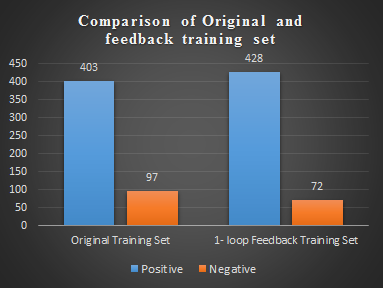

In [64]:
from IPython.display import Image
Image(filename='Model Improvement.png')

# Geographical Map - US states showing sentiment score

In [25]:
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [26]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
print states_abbrev

{'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'FL': 'Florida', 'WY': 'Wyoming', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NY': 'New York', 'RI': 'Rhode Island', 'NV': 'Nevada', 'GU': 'Guam', 'CO': 'Colorado', 'CA': 'California', 'GA': 'Georgia', 'CT': 'Connecticut', 'OK': 'Oklahoma', 'OH': 'Ohio', 'KS': 'Kansas', 'SC': 'South Carolina', 'KY': 'Kentucky', 'OR': 'Oregon', 'SD': 'South Dakota', 'DE': 'Delaware', 'DC': 'District of Columbia', 'HI': 'Hawaii', 'PR': 'Puerto Rico', 'TX': 'Texas', 'LA': 'Louisiana', 'TN': 'Tennessee', 'PA': 'Pennsylvania', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'AK': 'Alaska', 'AL': 'Alabama', 'AS': 'American Samoa', 'AR': 'Arkansas', 'VT': 'Vermont', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'AZ': 'Arizona', 'ID': 'Idaho', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'UT': 'Utah', 'MO': 'Missouri', 'MN': 'Minnesota', 'M

In [28]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

# look here for more info about defaultdict
# https://docs.python.org/2/library/collections.html#collections.defaultdict
#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("C:/Users/Jigar Mehta/Desktop/data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

# Look at this link that describes the * and ** for Python arguments
# https://docs.python.org/dev/tutorial/controlflow.html#more-on-defining-functions
# In brief, * and ** for accepting arbitrary number of arguments. * as tuples and ** as dictionary 
            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax



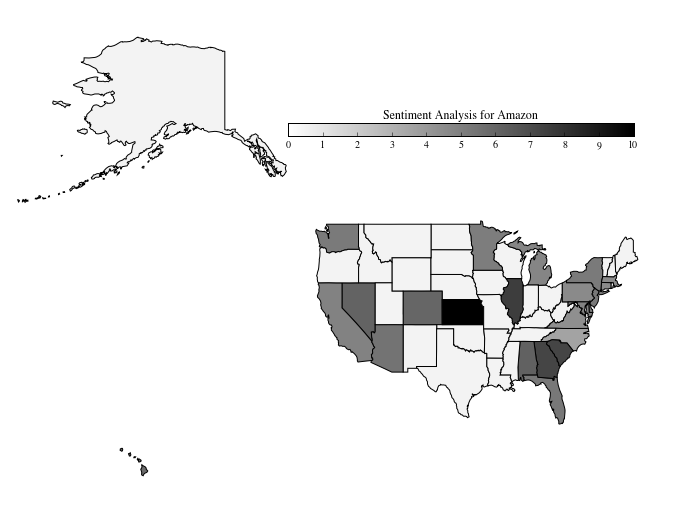

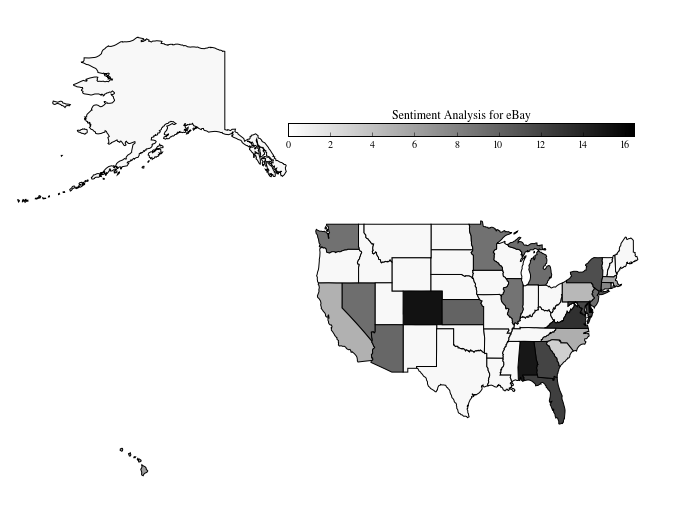

In [47]:
amaz= pd.read_csv("amaz_out.csv").set_index('State')
amaz.head()
ebay= pd.read_csv("ebay_out.csv").set_index('State')
ebay.head()
make_map(amaz.Sentiment_score, "Sentiment Analysis for Amazon");
make_map(ebay.Sentiment_score, "Sentiment Analysis for eBay");

# Top 10 States by highest Sentiment scores - amazon and eBay

C:\Anaconda2\lib\site-packages\pandas\tools\plotting.py:927: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


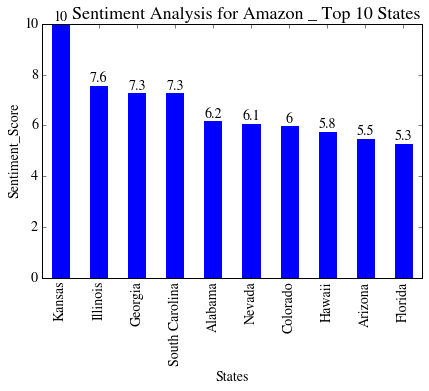

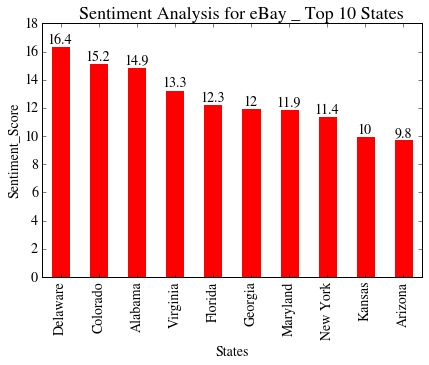

In [30]:
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import arange

values= [10,7.6,7.3,7.3,6.2,6.1,6,5.8,5.5,5.3]
freq_ = pd.Series.from_array(values)
#values = [500, 800, 900, 1000, 1400, 1600]
widths = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7,0.7,0.7,0.7,0.7]
colors = ['b', 'b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b']
lab=['Kansas','Illinois','Georgia','South Carolina','Alabama','Nevada','Colorado','Hawaii','Arizona','Florida']
# current figure, dont worry about this
fig = plt.figure(figsize=(15,10),dpi=150)
ax1 = fig.add_subplot(2,2,1)
ax1.grid(True,which='both')
ax1 = freq_.plot(kind='bar',colors=colors)
ax1.set_title("      Sentiment Analysis for Amazon _ Top 10 States",fontsize=18)
ax1.set_xlabel("States",fontsize=14)
ax1.set_ylabel("Sentiment_Score",fontsize=14)
ax1.set_xticklabels(lab)

rects1 = ax1.patches
fra= [10,7.6,7.3,7.3,6.2,6.1,6,5.8,5.5,5.3]
for rect, label in zip(rects1, fra):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height , label, ha='center', va='bottom')

plt.show()

values1= [16.4,15.2,14.9,13.3,12.3,12,11.9,11.4,10,9.8]

freq_1 = pd.Series.from_array(values1)
#values = [500, 800, 900, 1000, 1400, 1600]
widths = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7,0.7,0.7,0.7,0.7]
colors = ['r', 'r', 'r', 'r', 'r', 'r','r', 'r', 'r', 'r']
lab1=['Delaware','Colorado','Alabama','Virginia','Florida','Georgia','Maryland','New York','Kansas','Arizona']
# current figure, dont worry about this
fig = plt.figure(figsize=(15,10),dpi=150)
ax = fig.add_subplot(2,2,2)
ax.grid(True,which='both')
ax = freq_1.plot(kind='bar',colors=colors)
ax.set_title("    Sentiment Analysis for eBay _ Top 10 States",fontsize=18)
ax.set_xlabel("States",fontsize=14)
ax.set_ylabel("Sentiment_Score",fontsize=14)
ax.set_xticklabels(lab1)

rects = ax.patches

for rect, label in zip(rects, values1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height , label, ha='center', va='bottom')

plt.show()